# NLP (Natural Language Processing)

Veamos ahora cómo podríamos obtener algo de información extra de las opiniones de los usuarios, en términos muy elementales. Esta sección es un preliminar muy introductorio y básico de un amplio área de estudio conocida como *topic modelling*.

El archivo de "reviews" resultó no ser muy interesante, ya que solo contiene fechas de revisión para cada listado, lo que significa que solo es bueno para contar el número de revisiones. El archivo "reviews_details" contiene la misma información (y la misma cantidad de registros), con 4 columnas adicionales. Además, fusionamos host_id y host_names de la lista con el archivo reviews_details.

In [11]:
import pandas as pd
from utils.funciones import *
import matplotlib.pyplot as plt

# text mining
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [12]:
df_reviews = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/data/reviews.csv.gz', parse_dates=['date'])
#df_reviews.to_csv('input/reviews.csv', index=False)

In [13]:
df_listing = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/visualisations/listings.csv', index_col= ["id"])
#df_listing.to_csv('output/listings.csv', index=False)

In [14]:
df_oporto_review = df_listing # Copio el df aquí para usar las review después en la sección de la Nube de palabras

In [15]:
df_reviews = pd.merge(df_reviews, df_oporto_review[['host_id', 'host_name', 'name']], left_on = "listing_id", right_index=True, how = "left")
df_reviews = df_reviews.set_index('id')
df_reviews = df_reviews[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
df_reviews

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
4619901,41339,Porto city flat near the sea,180050,Paula,2013-05-15,200321,David,"Lovely bright, clean, quiet and airy apartment..."
6550958,41339,Porto city flat near the sea,180050,Paula,2013-08-16,1241699,Valentina,"Paula responsed very quickly, despite the fact..."
10305825,41339,Porto city flat near the sea,180050,Paula,2014-02-11,12007087,Carlos,Es muy amable y tiene mucha paciencia para los...
15714205,41339,Porto city flat near the sea,180050,Paula,2014-07-14,17261376,Anna,We loved our stay at Paula's apartment near th...
73035636,41339,Porto city flat near the sea,180050,Paula,2016-05-06,5443121,Yassine,"paula est une hote formidable, acceuillante et..."
...,...,...,...,...,...,...,...,...
774522889467673677,757762409716745291,GuestReady - Amazing Family house with a garden,465327816,Ramiro,2022-12-04,476495885,Juan Manuel,"Casa muy equipada, lugar tranquilo. Pequeños d..."
766523661689466565,757856247243057776,GuestReady - Cozy Bright apartment with a Balcony,487286529,Hugo,2022-11-23,3370089,Eduardo,"Aconchegante, pratico e bem localizado."
760747831732818330,758032180165009290,Big flat in the BEST location 4F,20323502,Idan,2022-11-15,486669408,Youri-Alvin,Clean and spacious apartment in the epicentre ...


In [16]:
%pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [17]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/enriquebook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/enriquebook/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
# Create a copy of the DataFrame to avoid warnings
df_reviews = df_reviews.copy()

# take out empty comments (530)
df_reviews = df_reviews[df_reviews['comments'].notnull()]

# remove non-alphanumeric characters and make everything lowercase
df_reviews.loc[:, 'comments'] = df_reviews['comments'].str.replace('[^a-zA-Z0-9\sáéíóúÁÉÍÓÚñÑçÇ~]+', '').str.lower()

# remove windows new line
df_reviews.loc[:, 'comments'] = df_reviews['comments'].str.replace('\r\n', "")

# remove stopwords (from nltk library)
stop_words = []
for language in ["english", "spanish", "french", "portuguese"]:
    stop_words.extend(stopwords.words(language))
df_reviews.loc[:, 'comments'] = df_reviews['comments'].apply(lambda x: " ".join([i for i in x.split() if i not in stop_words]))

# remove punctuation and replace x spaces by one space
df_reviews.loc[:, 'comments'] = df_reviews['comments'].str.replace('[^\w\s]', " ").str.replace('\s+', ' ')

df_reviews.comments.values[2]  # print same comments again

In [ ]:
texts = df_reviews.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
31,br,415953
79,porto,205546
5,apartment,198603
8,great,183780
9,location,147193
92,stay,140643
78,place,133129
271,très,129310
2,clean,101673
113,us,96046


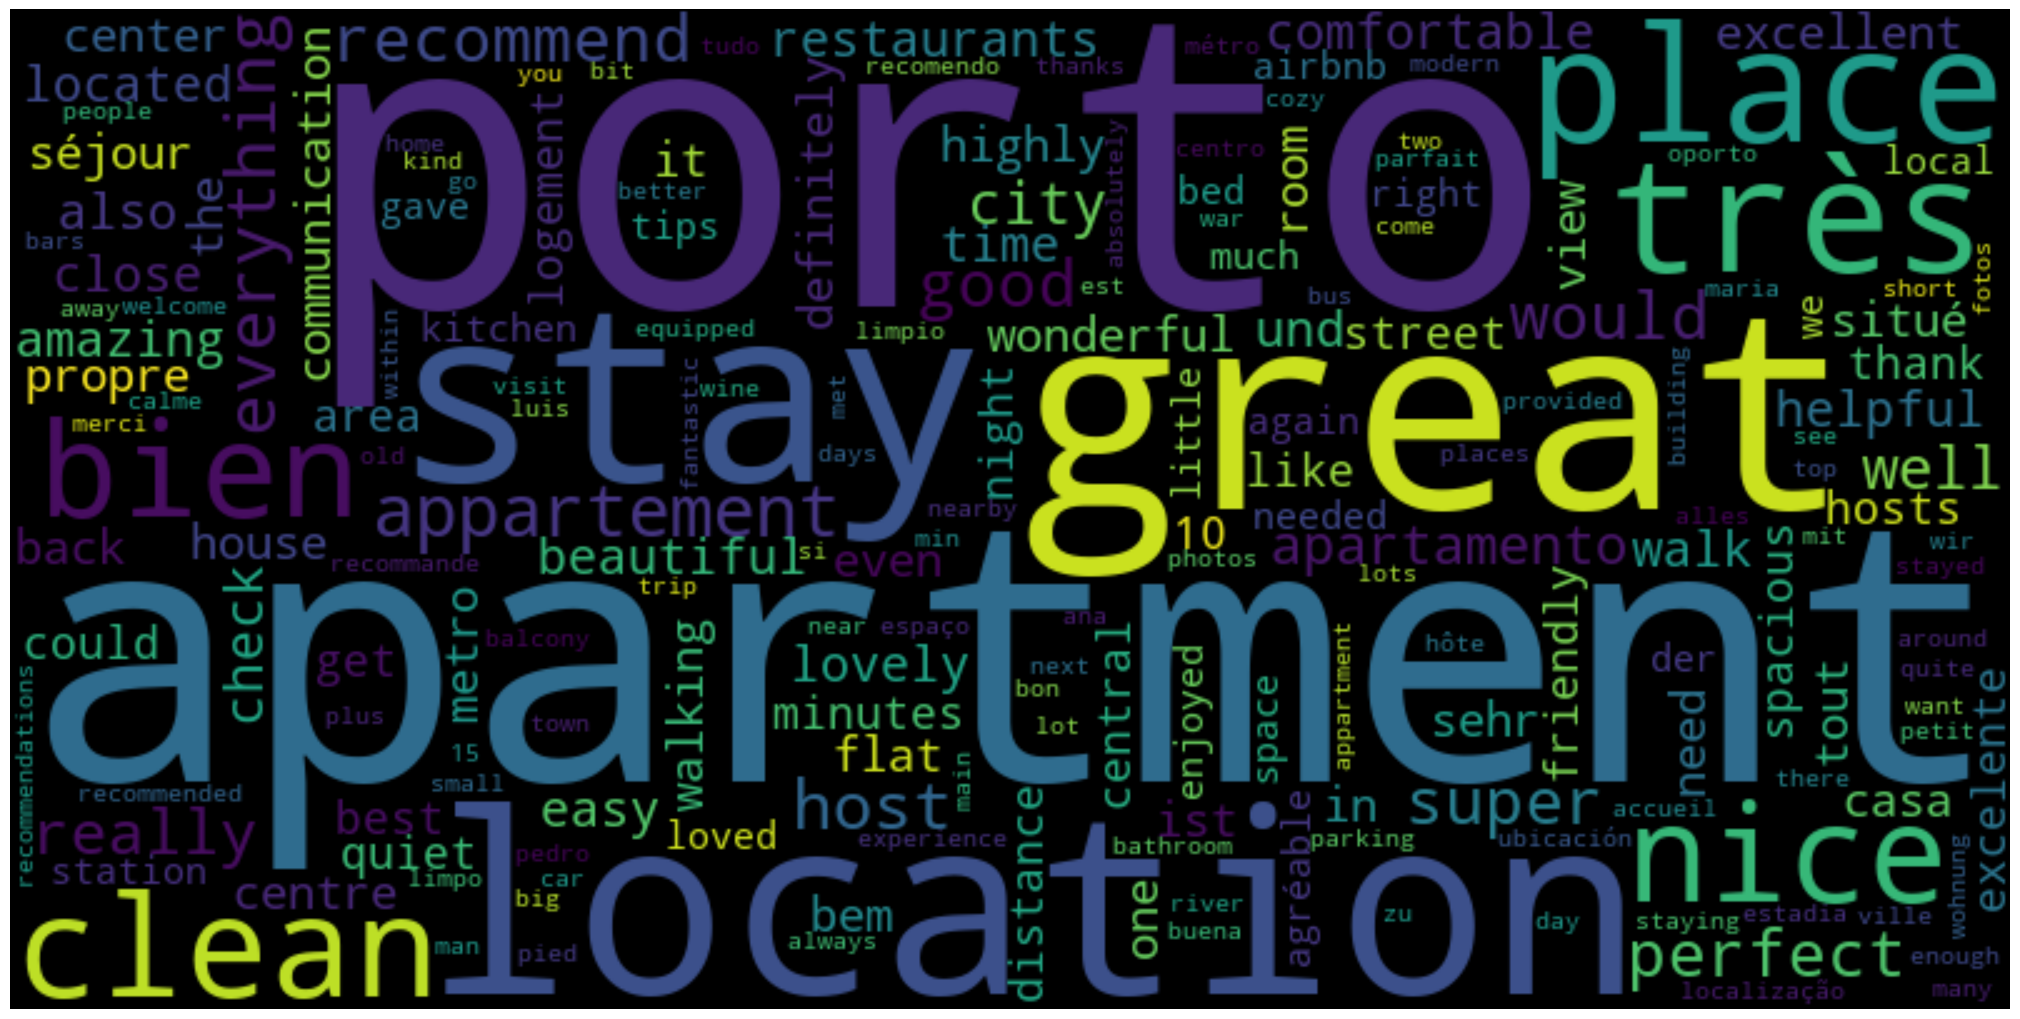

In [ ]:
excluded_words = ['br', 'us', 'die', 'made']
cvec_df = pd.DataFrame.from_records(words_freq, columns=['words', 'counts']).sort_values(by="counts", ascending=False)

# Filtrar las palabras excluidas
cvec_df = cvec_df[~cvec_df['words'].isin(excluded_words)]

cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('img/wordcloud.png')
plt.show()